# without global pool

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

# from torchvision import transforms

%matplotlib inline

In [2]:
env = gym.make("Pong-v0")

[2018-01-06 19:21:21,444] Making new env: Pong-v0


In [3]:
downsample = 2
output_size = 160//downsample

def preprocess(frame):
    '''from karpathy.'''
    I = frame
    I = I[35:195] # crop
    I = I[::downsample,::downsample,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    tensor = torch.from_numpy(I).float()
    return tensor.unsqueeze(0).unsqueeze(0) #BCHW

def clip_grads(net, low=-10, high=10):
    """Gradient clipping to the range [low, high]."""
    parameters = [param for param in net.parameters()
                  if param.grad is not None]
    for p in parameters:
        p.grad.data.clamp_(low, high)
        
if torch.cuda.is_available():
    def to_var(x, requires_grad=False, gpu=None):
        x = x.cuda(gpu)
        return Variable(x, requires_grad=requires_grad)
else:
    def to_var(x, requires_grad=False, gpu=None):
        return Variable(x, requires_grad=requires_grad)

In [4]:
class Net(nn.Module):
    '''very similar to Nature DQN.'''
    def __init__(self, action_n, input_shape=(1,80,80)):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_shape[0],16,kernel_size=8, stride=2),nn.ReLU(),
                                  nn.Conv2d(16,32,kernel_size=4, stride=2),nn.ReLU())
        flatten_size = self._get_flatten_size(input_shape)
        self.fc = nn.Linear(flatten_size, action_n)
    
    def _get_flatten_size(self, shape):
        x = Variable(torch.rand(1, *shape))
        output_feat = self.conv(x)
        n_size = output_feat.view(-1).size(0)
        return n_size
        
    def forward(self, x):
        feat = self.conv(x)
        logit = self.fc(feat.view(feat.size(0),-1))
        return logit

In [5]:
class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99, running_start=0,
#                 episode2thresh=lambda i: 0.05+0.9*np.exp(-1. * i / 100) if i>150 else 0): # eploration will start after 150 episodes
                 episode2thresh=lambda i: 0): # without exploration
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = running_start
        self.running_gamma = running_gamma
        self.episode2thresh = episode2thresh
        
    @property
    def episodes(self):
        return len(self.total_rewards)
        
    def select_action(self,obs):
        self.model.train()
        thresh=self.episode2thresh(self.episodes)
        action, log_prob = select_action(obs, self.model, thresh=thresh)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        self.model.eval()
        state = to_var(obs)
        prob = self.model(state)
        _, action = prob.max(dim=1)
        return action.data[0]

def select_action(obs, model, thresh=0):
    state = to_var(obs)
    logits = model(state)
    probs = F.softmax(logits, dim=1)
    m = Categorical(probs)
    action = m.sample()
#     if np.random.random()>thresh:
# #         print(probs)
#         try:
#             action = m.sample()
#         except:
#             print(probs,m)
#             raise
#     else:
#         action_space = probs.size(1)
#         action = to_var(torch.from_numpy(np.random.randint(action_space,size=1)))
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = to_var(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
#     print(ret)
    return ret

def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [6]:
net = Net(env.action_space.n, input_shape=(1,output_size,output_size))
if torch.cuda.is_available():
    net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=1.e-4,weight_decay=0.001)
trainer = PolicyGradient(model=net,running_start=-21)
writer = SummaryWriter()

In [7]:
import os

writer_path = list(writer.all_writers.keys())[0]
weight_join = lambda p: os.path.join(writer_path, p)

In [8]:
writer_path

'runs/Jan06_19-21-25_amax'

In [9]:
for episode in trange(100000):
    frame = env.reset()
    last_obs = preprocess(frame)
    curr_obs = preprocess(frame)
    total_reward = 0
    for step in range(100000): # not exceed 10000 steps
        action = trainer.select_action(obs=curr_obs-last_obs)
        frame, reward, done, _ = trainer.take_action(action, env, render=False)
        last_obs = curr_obs
        curr_obs = preprocess(frame)
        total_reward+=reward
        if done:
             break
    if step==100000:
        print("not enough!!!!!!!!!!!!!!!")
    policy_loss = trainer.get_loss_and_clear()
    writer.add_scalar("loss",policy_loss.data[0],episode)
    writer.add_scalar("reward",total_reward,episode)
#     print(policy_loss)
    optimizer.zero_grad()
    policy_loss.backward()
    clip_grads(trainer.model,-5,5)
    optimizer.step()
    running_reward = trainer.running_reward
    if episode%100==0:
        print(episode, total_reward,running_reward)
        torch.save(net.state_dict(), weight_join("episode%s.pth"%episode))
    if running_reward>1:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))

  0%|          | 1/100000 [00:03<97:22:17,  3.51s/it]

0 -21.0 -21.0


  0%|          | 101/100000 [04:00<60:47:25,  2.19s/it]

100 -21.0 -20.60003988479197


  0%|          | 201/100000 [08:04<66:25:24,  2.40s/it]

200 -20.0 -20.31959998606043


  0%|          | 301/100000 [12:06<64:02:42,  2.31s/it]

300 -21.0 -20.320732836342362


  0%|          | 401/100000 [16:09<72:04:21,  2.61s/it]

400 -20.0 -20.342961946651958


  1%|          | 501/100000 [20:15<64:53:05,  2.35s/it]

500 -21.0 -20.252606185330784


  1%|          | 601/100000 [24:17<68:55:34,  2.50s/it]

600 -20.0 -20.22231845371272


  1%|          | 701/100000 [28:31<70:42:48,  2.56s/it]

700 -21.0 -20.224567226904462


  1%|          | 801/100000 [33:01<68:32:56,  2.49s/it]

800 -20.0 -19.963226569468443


  1%|          | 901/100000 [37:41<81:40:35,  2.97s/it]

900 -19.0 -19.77328486511979


  1%|          | 1001/100000 [42:22<74:42:56,  2.72s/it]

1000 -19.0 -19.562786137118174


  1%|          | 1101/100000 [47:01<71:26:02,  2.60s/it]

1100 -20.0 -19.57925452791731


  1%|          | 1201/100000 [52:03<91:37:04,  3.34s/it]

1200 -20.0 -19.38045400428027


  1%|▏         | 1301/100000 [57:33<89:03:00,  3.25s/it]

1300 -20.0 -19.389766143118


  1%|▏         | 1401/100000 [1:02:56<89:55:16,  3.28s/it]

1400 -20.0 -19.306894639312485


  2%|▏         | 1501/100000 [1:08:49<108:38:48,  3.97s/it]

1500 -19.0 -19.501382920798143


  2%|▏         | 1601/100000 [1:15:10<107:17:06,  3.93s/it]

1600 -19.0 -19.40060317051487


  2%|▏         | 1701/100000 [1:21:47<113:59:46,  4.17s/it]

1700 -21.0 -19.462713508964896


  2%|▏         | 1801/100000 [1:28:56<119:01:27,  4.36s/it]

1800 -19.0 -19.1899354561199


  2%|▏         | 1901/100000 [1:36:35<139:44:27,  5.13s/it]

1900 -19.0 -19.085404361165168


  2%|▏         | 2001/100000 [1:45:00<143:06:45,  5.26s/it]

2000 -19.0 -19.059987364707926


  2%|▏         | 2101/100000 [1:53:52<145:29:30,  5.35s/it]

2100 -21.0 -18.877655958861315


  2%|▏         | 2201/100000 [2:03:29<184:42:07,  6.80s/it]

2200 -15.0 -18.885703436316735


  2%|▏         | 2301/100000 [2:13:36<187:04:32,  6.89s/it]

2300 -13.0 -18.59343540495268


  2%|▏         | 2401/100000 [2:24:36<179:17:52,  6.61s/it]

2400 -17.0 -18.761235954107065


  3%|▎         | 2501/100000 [2:35:14<177:44:49,  6.56s/it]

2500 -21.0 -18.432103487764998


  3%|▎         | 2601/100000 [2:46:19<175:15:19,  6.48s/it]

2600 -19.0 -18.482026587702094


  3%|▎         | 2701/100000 [2:57:39<186:37:40,  6.91s/it]

2700 -16.0 -18.478298117555063


  3%|▎         | 2801/100000 [3:09:30<197:28:54,  7.31s/it]

2800 -19.0 -18.446733448031285


  3%|▎         | 2901/100000 [3:22:00<193:33:41,  7.18s/it]

2900 -17.0 -17.96792909141187


  3%|▎         | 3001/100000 [3:34:34<211:36:05,  7.85s/it]

3000 -17.0 -18.05399215678493


  3%|▎         | 3101/100000 [3:47:49<209:14:23,  7.77s/it]

3100 -21.0 -17.77767968187933


  3%|▎         | 3201/100000 [4:01:02<209:04:55,  7.78s/it]

3200 -19.0 -17.835836708519103


  3%|▎         | 3301/100000 [4:14:42<220:40:28,  8.22s/it]

3300 -17.0 -17.867320156820874


  3%|▎         | 3401/100000 [4:28:27<243:32:22,  9.08s/it]

3400 -17.0 -17.97962341859746


  4%|▎         | 3501/100000 [4:42:15<222:44:33,  8.31s/it]

3500 -21.0 -17.816674974611736


  4%|▎         | 3601/100000 [4:56:05<202:19:16,  7.56s/it]

3600 -19.0 -17.881253345543275


  4%|▎         | 3701/100000 [5:10:38<229:31:25,  8.58s/it]

3700 -19.0 -17.50189918891488


  4%|▍         | 3801/100000 [5:25:15<251:32:19,  9.41s/it]

3800 -16.0 -17.343256015875085


  4%|▍         | 3901/100000 [5:40:32<250:30:35,  9.38s/it]

3900 -18.0 -17.237159211917565


  4%|▍         | 4001/100000 [5:56:08<266:17:57,  9.99s/it]

4000 -14.0 -16.712701435435694


  4%|▍         | 4101/100000 [6:12:21<253:06:48,  9.50s/it]

4100 -21.0 -16.894741959325994


  4%|▍         | 4201/100000 [6:27:48<257:41:30,  9.68s/it]

4200 -13.0 -17.14933013746818


  4%|▍         | 4301/100000 [6:43:55<272:25:20, 10.25s/it]

4300 -16.0 -16.7671888813158


  4%|▍         | 4401/100000 [7:00:19<278:24:05, 10.48s/it]

4400 -15.0 -16.590518446373455


  5%|▍         | 4501/100000 [7:16:31<262:11:56,  9.88s/it]

4500 -15.0 -16.564503095441722


  5%|▍         | 4601/100000 [7:33:08<252:43:11,  9.54s/it]

4600 -19.0 -16.3014005571913


  5%|▍         | 4701/100000 [7:49:39<269:01:01, 10.16s/it]

4700 -19.0 -16.37852939599007


  5%|▍         | 4801/100000 [8:06:22<277:40:29, 10.50s/it]

4800 -16.0 -16.197670494699913


  5%|▍         | 4901/100000 [8:23:35<293:11:49, 11.10s/it]

4900 -16.0 -15.973200444567023


  5%|▌         | 5001/100000 [8:40:50<285:51:22, 10.83s/it]

5000 -21.0 -16.201493541933626


  5%|▌         | 5101/100000 [8:58:24<269:42:47, 10.23s/it]

5100 -17.0 -16.0911352366159


  5%|▌         | 5201/100000 [9:15:43<266:19:28, 10.11s/it]

5200 -18.0 -15.963466935146231


  5%|▌         | 5301/100000 [9:32:52<287:14:33, 10.92s/it]

5300 -15.0 -15.96032625030695


  5%|▌         | 5401/100000 [9:50:46<265:10:00, 10.09s/it]

5400 -20.0 -15.583318193196686


  6%|▌         | 5501/100000 [10:08:36<302:26:59, 11.52s/it]

5500 -15.0 -15.580889350498074


  6%|▌         | 5601/100000 [10:27:16<288:24:23, 11.00s/it]

5600 -13.0 -15.23115615286711


  6%|▌         | 5701/100000 [10:45:20<268:57:51, 10.27s/it]

5700 -15.0 -15.220996558650453


  6%|▌         | 5801/100000 [11:03:39<291:21:25, 11.13s/it]

5800 -16.0 -15.172976324296448


  6%|▌         | 5901/100000 [11:21:39<281:24:38, 10.77s/it]

5900 -17.0 -15.052015688794873


  6%|▌         | 6001/100000 [11:40:16<280:43:45, 10.75s/it]

6000 -11.0 -14.887334645467027


  6%|▌         | 6101/100000 [11:58:16<273:49:00, 10.50s/it]

6100 -18.0 -15.154914060996486


  6%|▌         | 6201/100000 [12:16:59<276:50:43, 10.63s/it]

6200 -13.0 -14.795015751085492


  6%|▋         | 6301/100000 [12:35:30<290:51:07, 11.17s/it]

6300 -18.0 -15.077017950671364


  6%|▋         | 6401/100000 [12:53:49<288:40:14, 11.10s/it]

6400 -17.0 -15.256913138202883


  7%|▋         | 6501/100000 [13:13:09<299:36:51, 11.54s/it]

6500 -16.0 -15.018443732418126


  7%|▋         | 6601/100000 [13:31:30<266:04:28, 10.26s/it]

6600 -15.0 -15.258661554134527


  7%|▋         | 6701/100000 [13:50:06<287:08:00, 11.08s/it]

6700 -19.0 -15.15324498351507


  7%|▋         | 6801/100000 [14:09:15<300:43:29, 11.62s/it]

6800 -17.0 -14.852803757986118


  7%|▋         | 6901/100000 [14:28:12<292:33:30, 11.31s/it]

6900 -13.0 -14.851727195880878


  7%|▋         | 7001/100000 [14:47:02<301:13:05, 11.66s/it]

7000 -15.0 -14.855202239111483


  7%|▋         | 7101/100000 [15:06:54<283:52:40, 11.00s/it]

7100 -16.0 -14.64641898577159


  7%|▋         | 7201/100000 [15:26:10<289:41:03, 11.24s/it]

7200 -17.0 -15.193328629580215


  7%|▋         | 7301/100000 [15:45:26<308:32:35, 11.98s/it]

7300 -11.0 -14.892597493410003


  7%|▋         | 7401/100000 [16:05:05<307:41:59, 11.96s/it]

7400 -13.0 -14.490824074413721


  8%|▊         | 7501/100000 [16:24:57<310:23:42, 12.08s/it]

7500 -11.0 -14.636464672433497


  8%|▊         | 7601/100000 [16:44:51<308:51:00, 12.03s/it]

7600 -11.0 -14.732085291671554


  8%|▊         | 7701/100000 [17:04:51<324:24:26, 12.65s/it]

7700 -17.0 -14.289884720259149


  8%|▊         | 7801/100000 [17:24:51<329:58:30, 12.88s/it]

7800 -11.0 -14.443353733531094


  8%|▊         | 7901/100000 [17:44:41<325:26:38, 12.72s/it]

7900 -14.0 -14.430058789629923


  8%|▊         | 8001/100000 [18:05:19<364:41:59, 14.27s/it]

8000 -14.0 -14.508057548364762


  8%|▊         | 8101/100000 [18:26:54<338:15:00, 13.25s/it]

8100 -16.0 -14.065244931439427


  8%|▊         | 8201/100000 [18:46:51<261:59:58, 10.27s/it]

8200 -17.0 -14.332221954233036


  8%|▊         | 8301/100000 [19:06:44<304:54:55, 11.97s/it]

8300 -13.0 -14.575886608631441


  8%|▊         | 8401/100000 [19:27:29<318:19:22, 12.51s/it]

8400 -17.0 -14.421172156960093


  9%|▊         | 8501/100000 [19:47:28<346:49:30, 13.65s/it]

8500 -13.0 -14.713580714549236


  9%|▊         | 8601/100000 [20:08:21<355:22:11, 14.00s/it]

8600 -14.0 -13.96940116949331


  9%|▊         | 8701/100000 [20:28:33<320:49:42, 12.65s/it]

8700 -15.0 -14.12658674715581


  9%|▉         | 8801/100000 [20:49:17<307:26:54, 12.14s/it]

8800 -15.0 -13.945878392301044


  9%|▉         | 8901/100000 [21:09:58<311:53:57, 12.33s/it]

8900 -15.0 -14.089840685450273


  9%|▉         | 9001/100000 [21:30:06<313:17:48, 12.39s/it]

9000 -14.0 -14.094263600507123


  9%|▉         | 9101/100000 [21:51:02<344:29:42, 13.64s/it]

9100 -13.0 -14.038074409255291


  9%|▉         | 9201/100000 [22:11:24<311:47:50, 12.36s/it]

9200 -11.0 -14.198927847840423


  9%|▉         | 9301/100000 [22:31:47<281:19:11, 11.17s/it]

9300 -18.0 -14.412944628647843


  9%|▉         | 9401/100000 [22:53:18<310:58:28, 12.36s/it]

9400 -14.0 -13.950608522727604


 10%|▉         | 9501/100000 [23:15:30<351:01:48, 13.96s/it]

9500 -12.0 -13.464882014754686


 10%|▉         | 9601/100000 [23:37:17<320:33:45, 12.77s/it]

9600 -12.0 -13.558708932087445


 10%|▉         | 9701/100000 [23:59:01<302:53:10, 12.08s/it]

9700 -20.0 -13.75207968448623


 10%|▉         | 9801/100000 [24:20:13<309:24:00, 12.35s/it]

9800 -9.0 -13.887135600806634


 10%|▉         | 9901/100000 [24:41:37<305:32:19, 12.21s/it]

9900 -17.0 -13.750805221256952


 10%|█         | 10001/100000 [25:03:02<337:50:03, 13.51s/it]

10000 -13.0 -14.167642392448178


 10%|█         | 10101/100000 [25:24:58<341:05:32, 13.66s/it]

10100 -9.0 -14.052455979987782


 10%|█         | 10194/100000 [25:45:51<350:22:11, 14.05s/it]

KeyboardInterrupt: 

In [ ]:
# much slower than batch, stop!

In [10]:
torch.save(net.state_dict(), weight_join("final.pth"))

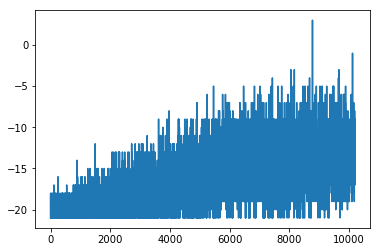

In [11]:
plt.plot(trainer.total_rewards)

In [12]:
writer_path

'runs/Jan06_19-21-25_amax'